In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt


import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_excel('/content/passenger (1).xlsx',header=None)

In [4]:
df.columns = ['year','passengers']

In [6]:
df.head()

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [10]:
df.shape

(144, 2)

In [11]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [12]:
y = df.set_index('year')

In [14]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='year', length=144, freq=None)

In [15]:
y.isnull().sum()

passengers    0
dtype: int64

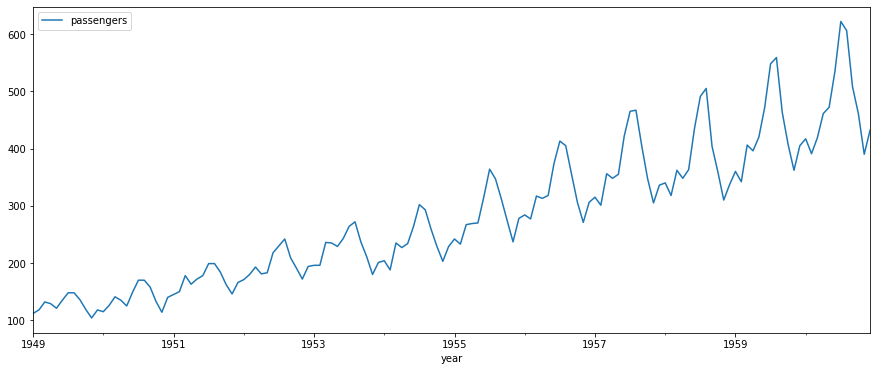

In [16]:
y.plot(figsize=(15, 6))
plt.show()

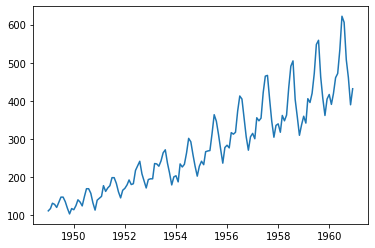

In [17]:
plt.plot(y)

In [18]:
from statsmodels.tsa.stattools import adfuller
#H0:IT IS NON STATIONARY
#H1:IT IS  STATIONARY

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

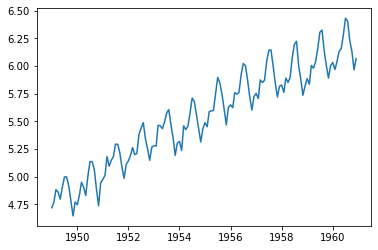

In [20]:
ts_log = np.log(y)  # USE LOG SCALE
plt.plot(ts_log)

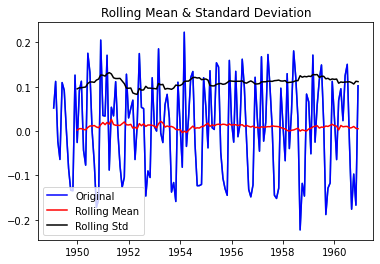

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [21]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift(1)  # DIFFERENCING OREDER =1 ======ARIMA 
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)                           #stationary  series

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

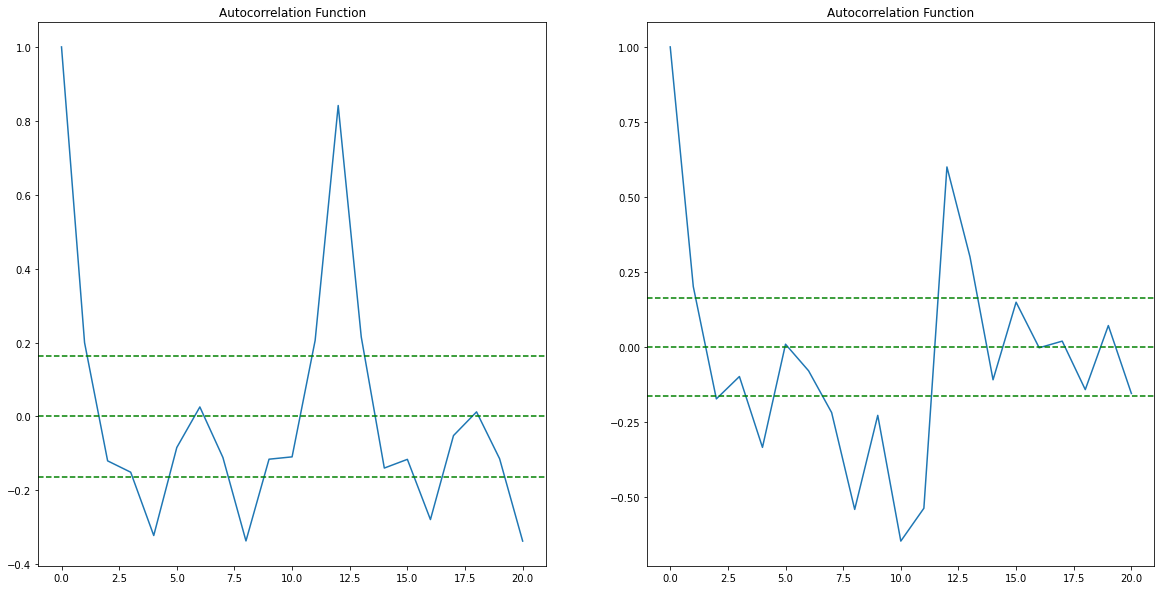

In [22]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(ts_log_diff, nlags=20)
lag_pacf=pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


plotting ARIMA model


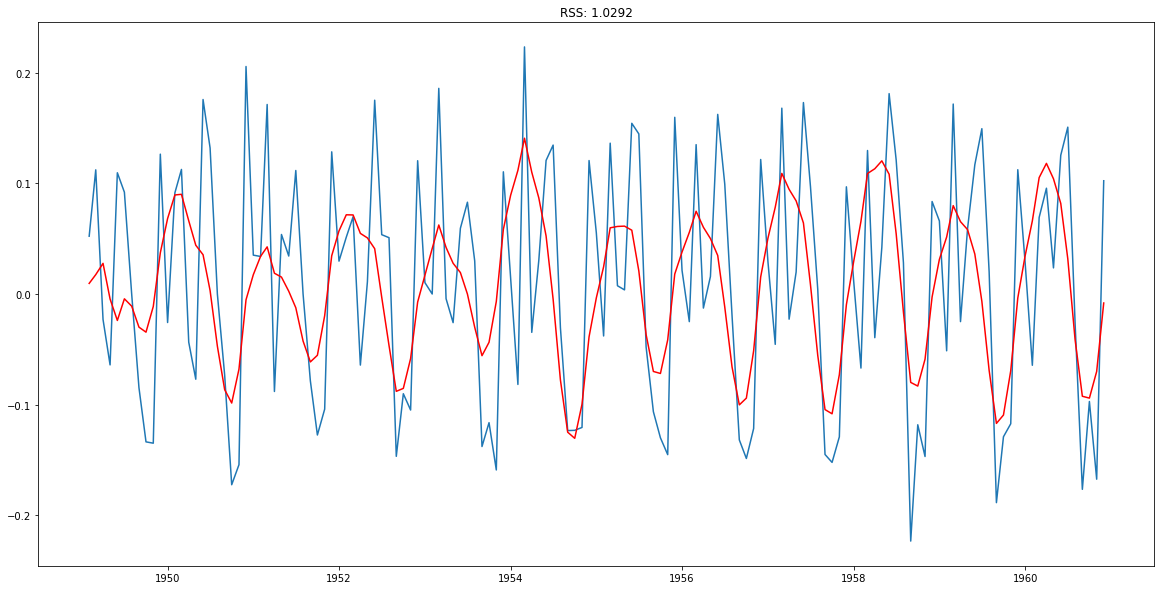

In [23]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(ts_log , order=(2,1,2))  #log transformation
results=model.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-ts_log_diff)**2))
print('plotting ARIMA model')

In [24]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

year
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [25]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

year
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [26]:
predictions_log=pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

year
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773240
1949-05-01    4.768720
dtype: float64

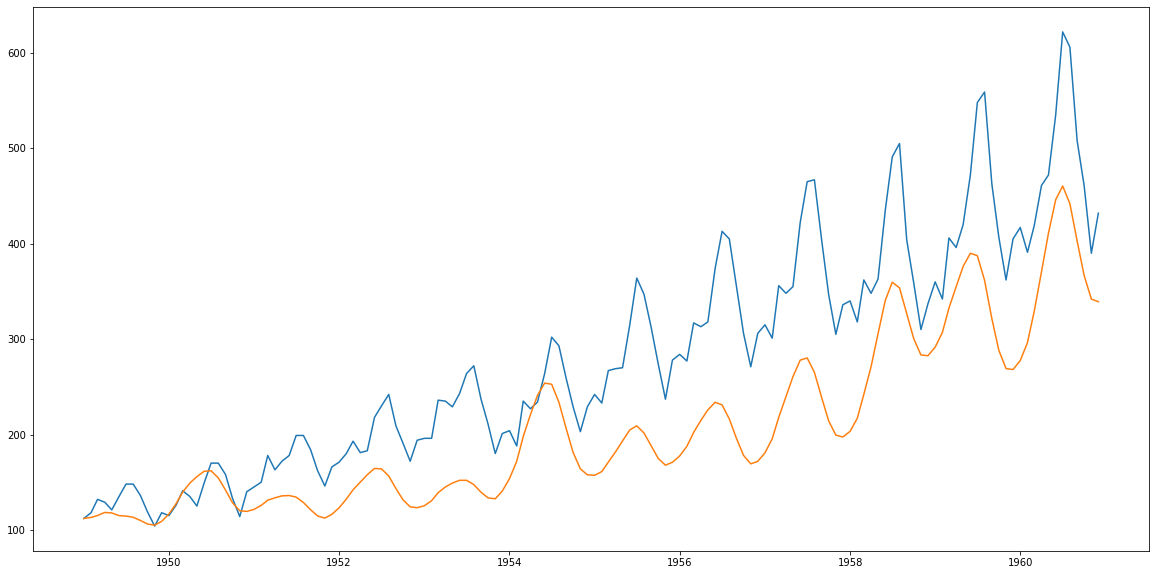

In [27]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(y)
plt.plot(predictions_ARIMA)

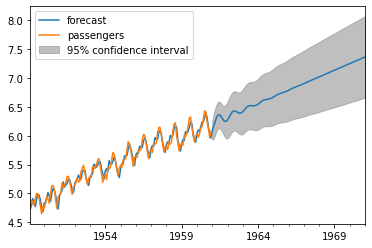

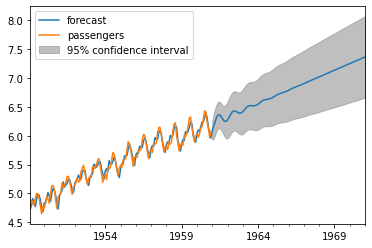

In [28]:
results.plot_predict(1,264)    #144 + 12*10         (12*12 )+(12*10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


plotting AR model


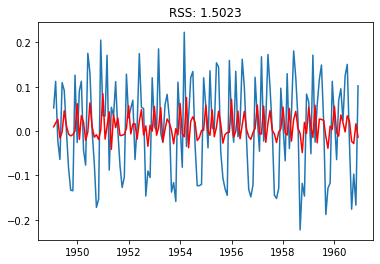

In [29]:
model1=ARIMA(ts_log , order=(2,1,0))#AR MODEL
results1=model1.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results1.fittedvalues-ts_log_diff)**2))
print('plotting AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


plotting ma model


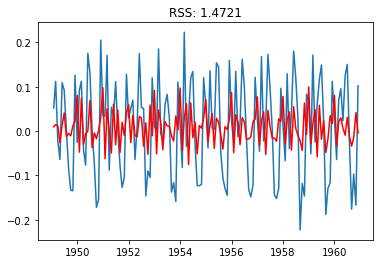

In [30]:
model1=ARIMA(ts_log , order=(0,1,2))#MA MODEL
results1=model1.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results1.fittedvalues-ts_log_diff)**2))
print('plotting ma model')